<a href="https://colab.research.google.com/github/Mc4minta/AIB5-PcapAttackClassifier/blob/main/EvaluateBaselinePacket_Bruteforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# list pcap zip
import os
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
for file in files:
  print(file)

DoS.zip
DDoS.zip
PortScan.zip
Benign.zip
DoS-HTTP-Flood.zip
Benign2.zip
DoS-overall.zip
DoS-Layer3and4.zip
FTP-Bruteforce.zip
SSH-Bruteforce.zip
DoS-Slow-Rate.zip


In [3]:
# list each attack folder without '.zip' and append to attacks[]
pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
files = os.listdir(pcap_zip_dir)
attacks = []
for file in files:
  attacks.append(file[:-4])
for attack in attacks:
  print(attack)

DoS
DDoS
PortScan
Benign
DoS-HTTP-Flood
Benign2
DoS-overall
DoS-Layer3and4
FTP-Bruteforce
SSH-Bruteforce
DoS-Slow-Rate


In [4]:
# define function to unzip(attack.zip)
import zipfile

def unzip_attack_zip(attack):
  pcap_zip_dir = '/content/drive/MyDrive/Share to Mc4/AIBuilders5-MiN/TestsetForBaseline/'
  if(attack[-4:]=='.zip'):
    zip_file_name = attack
  else:
    zip_file_name = attack + '.zip'
  zip_file_path = os.path.join(pcap_zip_dir, zip_file_name)
  destination_directory = '/content/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_directory)
    print(f"'{zip_file_name}' unzipped to '{destination_directory}'.")
  except Exception as e:
      print(f"Error : {e}")

# unzip_attack_zip('DDoS')

In [5]:
attacks = ['FTP-Bruteforce','SSH-Bruteforce']

In [6]:
# iterate through each attack .zip and unzip it
for attack in attacks:
  print(f"Processing {attack}...")
  if(attack not in os.listdir('/content/')):
    unzip_attack_zip(attack)
  else:
    print(f"{attack} already unzipped")

Processing FTP-Bruteforce...
'FTP-Bruteforce.zip' unzipped to '/content/'.
Processing SSH-Bruteforce...
'SSH-Bruteforce.zip' unzipped to '/content/'.


# Prediction setup (speed run)

In [7]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.7 MB/s eta 0:00:00


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scapy.all import PcapReader, IP, TCP
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()

# Load tokenizer and model once (replace model path with your model)
tokenizer = AutoTokenizer.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
model = AutoModelForSequenceClassification.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload").to(device)
model.eval()

classes = [
    'Analysis', 'Backdoor', 'Bot', 'DDoS', 'DoS', 'DoS GoldenEye', 'DoS Hulk',
    'DoS SlowHTTPTest', 'DoS Slowloris', 'Exploits', 'FTP Patator', 'Fuzzers',
    'Generic', 'Heartbleed', 'Infiltration', 'Normal', 'Port Scan',
    'Reconnaissance', 'SSH Patator', 'Shellcode', 'Web Attack - Brute Force',
    'Web Attack - SQL Injection', 'Web Attack - XSS', 'Worms'
]

classes_mapping = {
    'Analysis': 'Other', 'Backdoor': 'Other', 'Bot': 'Other', 'DDoS': 'Other',
    'DoS': 'DoS', 'DoS GoldenEye': 'DoS-HTTP-Flood', 'DoS Hulk': 'DoS-HTTP-Flood',
    'DoS SlowHTTPTest': 'DoS-Slow-Rate', 'DoS Slowloris': 'DoS-Slow-Rate',
    'Exploits': 'Other', 'FTP Patator': 'FTP-Bruteforce', 'Fuzzers': 'Other',
    'Generic': 'Other', 'Heartbleed': 'Other', 'Infiltration': 'Other',
    'Normal': 'Benign', 'Port Scan': 'PortScan', 'Reconnaissance': 'Other',
    'SSH Patator': 'SSH-Bruteforce', 'Shellcode': 'Other',
    'Web Attack - Brute Force': 'Other', 'Web Attack - SQL Injection': 'Other',
    'Web Attack - XSS': 'Other', 'Worms': 'Other',
}

packets_brief = {}

def processing_packet_conversion(packet):
    packet_2 = packet
    protocol_counts = {}
    protocols = []

    while packet_2:
        layer = packet_2[0]
        protocol_counts[layer.name] = protocol_counts.get(layer.name, 0) + 1
        protocols.append(layer.name)

        if not layer.payload:
            break
        packet_2 = layer.payload

    src_ip = packet[IP].src
    dst_ip = packet[IP].dst
    src_port = packet.sport
    dst_port = packet.dport
    ip_length = len(packet[IP])
    ip_ttl = packet[IP].ttl
    ip_tos = packet[IP].tos
    tcp_data_offset = packet[TCP].dataofs
    tcp_flags = packet[TCP].flags

    payload_bytes = bytes(packet.payload)
    payload_length = len(payload_bytes)
    payload_decimal = ' '.join(str(byte) for byte in payload_bytes)

    final_data = (
        "0 0 195 -1 "
        f"{src_port} {dst_port} {ip_length} {payload_length} "
        f"{ip_ttl} {ip_tos} {tcp_data_offset} {int(tcp_flags)} -1 {payload_decimal}"
    )
    return final_data

def create_results_dataframe(predictions):
    df = pd.DataFrame({
        'Packet_Indices': list(range(len(predictions))),
        'Predicted_Attack': [classes[p] for p in predictions]
    })
    df['Result'] = df['Predicted_Attack'].map(classes_mapping)
    return df

def batch_predict_pcap(file_path, batch_size=32, filter_bytes=None):
    global model

    texts = []
    packets_nbr = 0

    with PcapReader(file_path) as pcap:
        for pkt in pcap:
            if IP in pkt and TCP in pkt:
                payload_bytes = bytes(pkt.payload)
                if filter_bytes is None or filter_bytes in payload_bytes:
                    text = processing_packet_conversion(pkt)
                    if text:
                        texts.append(text[:1024])  # truncate to 1024 chars
                        packets_nbr += 1

    print(f"Collected {packets_nbr} TCP/IPv4 packets matching filter")

    if not texts:
        print("No packets to process.")
        return pd.DataFrame()  # Return empty dataframe if no data

    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    if use_fp16:
        model = model.half()

    all_preds = []
    packets_brief.clear()  # Clear previous counts

    for batch in loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if use_fp16:
            attention_mask = attention_mask.half()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().tolist()

            for pred in preds:
                pred_class = classes[pred]
                if pred_class != "Normal":
                    packets_brief[pred_class] = packets_brief.get(pred_class, 0) + 1

            all_preds.extend(preds)

    # Print summary
    for attack, count in packets_brief.items():
        print(f"{attack}: {count}")

    # Plot results
    if packets_brief:
        keys = list(packets_brief.keys())
        vals = list(packets_brief.values())
        plt.bar(keys, vals)
        plt.xlabel('Attacks')
        plt.ylabel('Count')
        plt.title('Detected possible attacks')
        plt.show()
    else:
        print("No attacks detected.")

    # Return DataFrame with detailed predictions
    return create_results_dataframe(all_preds)


# Example usage:
# df_results = batch_predict_pcap("/content/bruteforce.pcap")
# print(df_results.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [9]:
for attack in attacks:
  print(f"Processing {attack}...")
  os.makedirs(f'/content/{attack}_prediction', exist_ok=True)

Processing FTP-Bruteforce...
Processing SSH-Bruteforce...


Processing FTP-Bruteforce...
  Processing bruteforce_ftp.pcap...
Collected 49739 TCP/IPv4 packets matching filter
DoS GoldenEye: 968
DDoS: 3
Fuzzers: 291
DoS SlowHTTPTest: 312
FTP Patator: 163
Generic: 19
Web Attack - Brute Force: 10
Heartbleed: 2
Exploits: 3
DoS: 1


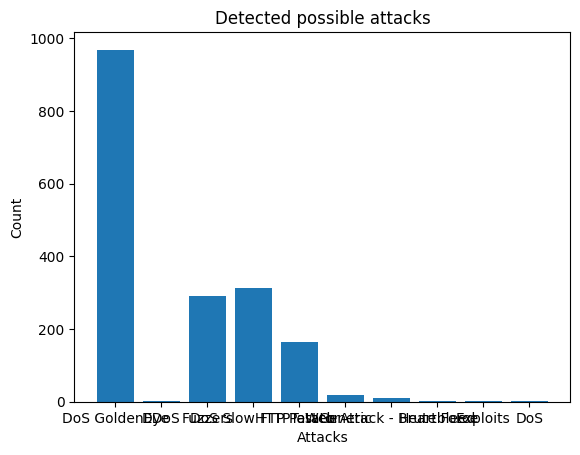

    Saved to /content/FTP-Bruteforce_prediction/bruteforce_ftp_prediction.csv
  Processing ftpbrute-kali.pcap...
Collected 13838 TCP/IPv4 packets matching filter
DoS SlowHTTPTest: 202
DoS GoldenEye: 484
FTP Patator: 162
Web Attack - Brute Force: 9
Fuzzers: 8


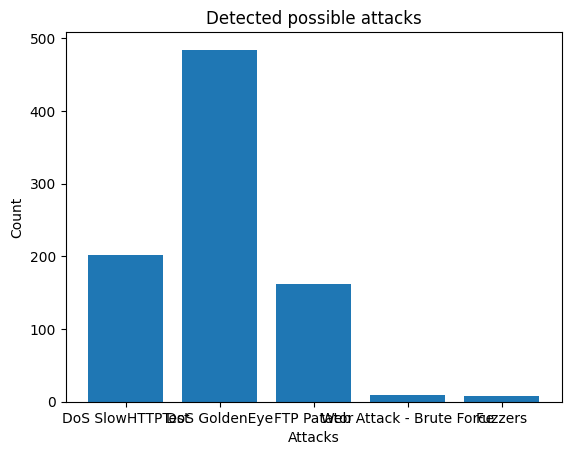

    Saved to /content/FTP-Bruteforce_prediction/ftpbrute-kali_prediction.csv
  Processing ftpbrute-ubuntu.pcap...
Collected 20225 TCP/IPv4 packets matching filter
DoS SlowHTTPTest: 287
Web Attack - Brute Force: 20
DoS GoldenEye: 572
Fuzzers: 5
FTP Patator: 248
Bot: 40


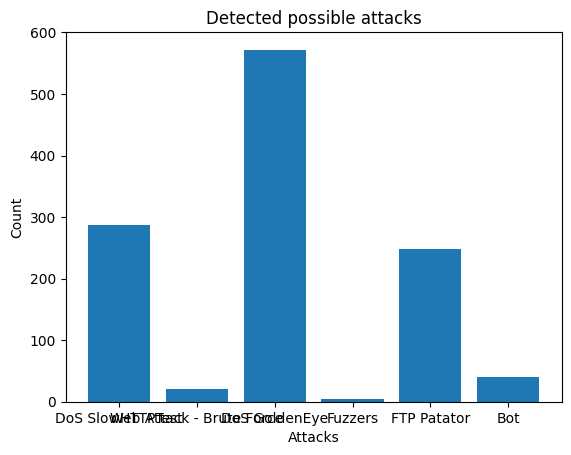

    Saved to /content/FTP-Bruteforce_prediction/ftpbrute-ubuntu_prediction.csv
Processing SSH-Bruteforce...
  Processing sshbrute-ubuntu.pcap...
Collected 27936 TCP/IPv4 packets matching filter
SSH Patator: 7197
DoS GoldenEye: 2


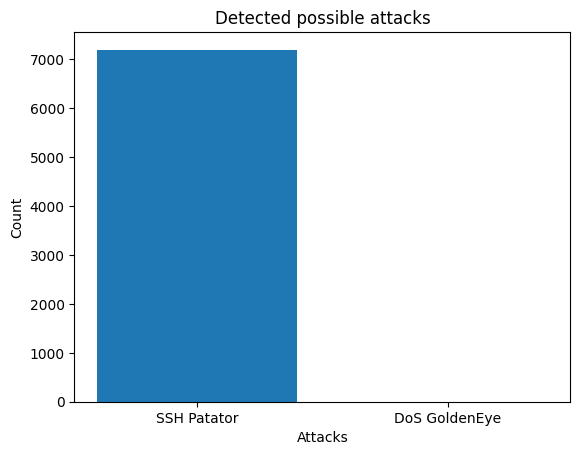

    Saved to /content/SSH-Bruteforce_prediction/sshbrute-ubuntu_prediction.csv
  Processing sshbrute-kali.pcap...
Collected 26951 TCP/IPv4 packets matching filter
SSH Patator: 6848
DoS GoldenEye: 3


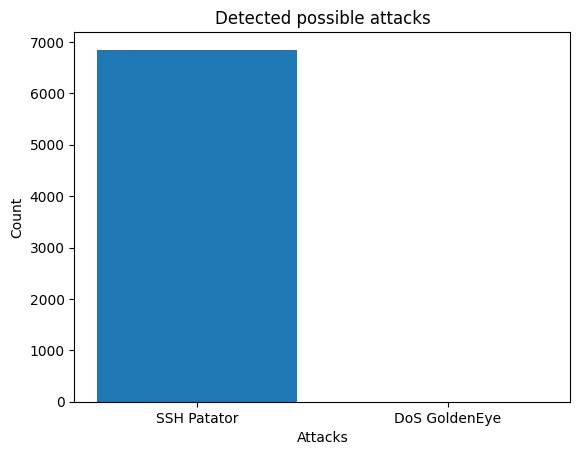

    Saved to /content/SSH-Bruteforce_prediction/sshbrute-kali_prediction.csv
  Processing bruteforce_ssh.pcap...
Collected 112188 TCP/IPv4 packets matching filter
SSH Patator: 46020
DoS GoldenEye: 3
Port Scan: 2


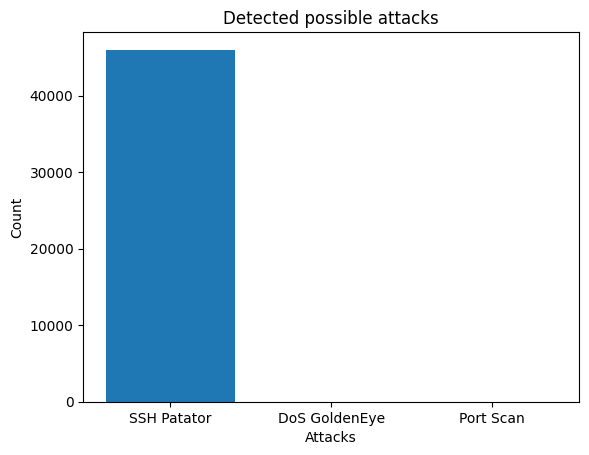

    Saved to /content/SSH-Bruteforce_prediction/bruteforce_ssh_prediction.csv


In [10]:
for attack in attacks:
  print(f"Processing {attack}...")
  files = os.listdir(f'/content/{attack}')
  for file in files:
    if not file.endswith('.pcap'):
        continue
    print(f"  Processing {file}...")

    prediction_file_name = file.replace('.pcap', '_prediction.csv')
    prediction_file_path = f'/content/{attack}_prediction/{prediction_file_name}'

    df_results = batch_predict_pcap(f'/content/{attack}/{file}', filter_bytes=b"")

    df_results.to_csv(prediction_file_path, index=False)
    print(f"    Saved to {prediction_file_path}")

In [11]:
# just seeing choosen_label value counts

for attack in attacks:
  pcap_files = os.listdir(f'/content/{attack}')
  for pcap_file in pcap_files:
    if not pcap_file.endswith('.pcap'):
        continue

    file_name = pcap_file.split('.')[0]
    pcap_file_name = f'{file_name}.pcap'
    pcap_file_dir = f'/content/{attack}/'

    csv_file_name = f'{file_name}_ISCX.csv'
    csv_file_dir = f'/content/{attack}_csv/'

    index_file_name = f'{file_name}_index.csv'
    index_file_dir = f'/content/{attack}_index/'

    prediction_file_name = f'{file_name}_prediction.csv'
    prediction_file_dir = f'/content/{attack}_prediction/'

    df = pd.read_csv(f'{prediction_file_dir}/{prediction_file_name}')
    print(f"Processing {pcap_file_name}")
    print('--')
    print(df['Result'].value_counts())
    print('--')
    print(df['Predicted_Attack'].value_counts())

Processing bruteforce_ftp.pcap
--
Result
Benign            47967
DoS-HTTP-Flood      968
Other               328
DoS-Slow-Rate       312
FTP-Bruteforce      163
DoS                   1
Name: count, dtype: int64
--
Predicted_Attack
Normal                      47967
DoS GoldenEye                 968
DoS SlowHTTPTest              312
Fuzzers                       291
FTP Patator                   163
Generic                        19
Web Attack - Brute Force       10
DDoS                            3
Exploits                        3
Heartbleed                      2
DoS                             1
Name: count, dtype: int64
Processing ftpbrute-kali.pcap
--
Result
Benign            12973
DoS-HTTP-Flood      484
DoS-Slow-Rate       202
FTP-Bruteforce      162
Other                17
Name: count, dtype: int64
--
Predicted_Attack
Normal                      12973
DoS GoldenEye                 484
DoS SlowHTTPTest              202
FTP Patator                   162
Web Attack - Brute Force   

In [12]:
# prompt: # prompt: modified the code that the attack result will stillb e for each attack but all will save to the Result folder with the file name of {attack}_resu def get_most_common_non_benign(df):
# #     """
# #     Finds the most frequent non-Benign label in the 'Result' column of a DataFrame.
# #     Returns 'Unknown' if no non-Benign labels are found.
# #     """
# #     non_benign_results = df[df['Result'] != 'Benign']['Result']
# #     if not non_benign_results.empty:
# #         return non_benign_results.mode()[0]
# #     else:
# #         return 'Unknown'
# # # Create a single empty dataframe for the overall result
# # overall_summary_df = pd.DataFrame(columns=['FileName', 'Result', 'Attack'])
# # # Create the single 'result' directory
# # result_dir = '/content/Result'
# # os.makedirs(result_dir, exist_ok=True)
# # # Iterate through each attack and its corresponding prediction files
# # for attack in attacks:
# #     print(f"Analyzing predictions for {attack}...")
# #     prediction_dir = f'/content/{attack}_prediction/'
# #     if os.path.exists(prediction_dir):
# #         prediction_files = os.listdir(prediction_dir)
# #         for pred_file in prediction_files:
# #             if pred_file.endswith('_prediction.csv'):
# #                 prediction_file_path = os.path.join(prediction_dir, pred_file)
# #                 try:
# #                     df_prediction = pd.read_csv(prediction_file_path)
# #                     # Get the most common non-Benign label
# #                     chosen_label = get_most_common_non_benign(df_prediction)
# #                     # Append the information to the overall summary dataframe
# #                     new_row = pd.DataFrame({
# #                         'FileName': [pred_file],
# #                         'Result': [chosen_label],
# #                         'Attack': [attack]  # This is the true label based on the folder name
# #                     })
# #                     overall_summary_df = pd.concat([overall_summary_df, new_row], ignore_index=True)
# #                     print

def get_most_common_non_benign(df):
  """
    Finds the most frequent non-Benign label in the 'Result' column of a DataFrame.
    Returns 'Unknown' if no non-Benign labels are found.
    """
  non_benign_results = df[df['Result'] != 'Benign']['Result']
  if not non_benign_results.empty:
    return non_benign_results.mode()[0]
  else:
    return 'Unknown'

# Create the single 'Result' directory
result_dir = '/content/Result'
os.makedirs(result_dir, exist_ok=True)

# Iterate through each attack and its corresponding prediction files
for attack in attacks:
  print(f"Analyzing predictions for {attack}...")
  prediction_dir = f'/content/{attack}_prediction/'
  if os.path.exists(prediction_dir):
    prediction_files = os.listdir(prediction_dir)
    # Create a dataframe for the current attack's results
    attack_summary_df = pd.DataFrame(columns=['FileName', 'Result', 'Attack'])
    for pred_file in prediction_files:
      if pred_file.endswith('_prediction.csv'):
        prediction_file_path = os.path.join(prediction_dir, pred_file)
        try:
          df_prediction = pd.read_csv(prediction_file_path)

          # Get the most common non-Benign label
          chosen_label = get_most_common_non_benign(df_prediction)

          # Append the information to the current attack's summary dataframe
          new_row = pd.DataFrame({
              'FileName': [pred_file],
              'Result': [chosen_label],
              'Attack': [attack]  # This is the true label based on the folder name
          })
          attack_summary_df = pd.concat(
              [attack_summary_df, new_row], ignore_index=True
          )

          print(
              f"  Processed {pred_file}: Most common non-Benign result is"
              f" '{chosen_label}'"
          )

        except Exception as e:
          print(f"  Error processing {pred_file}: {e}")

    # Save the current attack's summary dataframe to a CSV file in the 'Result' directory
    output_filename = f'{attack}_result.csv'
    output_path = os.path.join(result_dir, output_filename)
    attack_summary_df.to_csv(output_path, index=False)
    print(f"Saved summary for {attack} to {output_path}")

  else:
    print(f"  Prediction directory not found for {attack}: {prediction_dir}")

Analyzing predictions for FTP-Bruteforce...
  Processed bruteforce_ftp_prediction.csv: Most common non-Benign result is 'DoS-HTTP-Flood'
  Processed ftpbrute-ubuntu_prediction.csv: Most common non-Benign result is 'DoS-HTTP-Flood'
  Processed ftpbrute-kali_prediction.csv: Most common non-Benign result is 'DoS-HTTP-Flood'
Saved summary for FTP-Bruteforce to /content/Result/FTP-Bruteforce_result.csv
Analyzing predictions for SSH-Bruteforce...
  Processed sshbrute-ubuntu_prediction.csv: Most common non-Benign result is 'SSH-Bruteforce'
  Processed sshbrute-kali_prediction.csv: Most common non-Benign result is 'SSH-Bruteforce'
  Processed bruteforce_ssh_prediction.csv: Most common non-Benign result is 'SSH-Bruteforce'
Saved summary for SSH-Bruteforce to /content/Result/SSH-Bruteforce_result.csv


In [13]:
# prompt: generated sklearn classification result of each attack_result with y_test being Attack column and y_pred being Result column

from sklearn.metrics import classification_report

for attack in attacks:
  result_csv_path = f'/content/Result/{attack}_result.csv'
  if os.path.exists(result_csv_path):
    df_result = pd.read_csv(result_csv_path)

    y_true = df_result['Attack']
    y_pred = df_result['Result']

    print(f"Classification Report for {attack}:")
    print(classification_report(y_true, y_pred, zero_division=0)) # Use zero_division=0 to handle cases where a class has no predicted samples

  else:
    print(f"No result file found for {attack}.")
  print("-" * 40)

Classification Report for FTP-Bruteforce:
                precision    recall  f1-score   support

DoS-HTTP-Flood       0.00      0.00      0.00       0.0
FTP-Bruteforce       0.00      0.00      0.00       3.0

      accuracy                           0.00       3.0
     macro avg       0.00      0.00      0.00       3.0
  weighted avg       0.00      0.00      0.00       3.0

----------------------------------------
Classification Report for SSH-Bruteforce:
                precision    recall  f1-score   support

SSH-Bruteforce       1.00      1.00      1.00         3

      accuracy                           1.00         3
     macro avg       1.00      1.00      1.00         3
  weighted avg       1.00      1.00      1.00         3

----------------------------------------


In [14]:
from sklearn.metrics import classification_report

all_true_labels = []
all_predicted_labels = []

for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)
            # The true label for all packets in this file is the 'attack' name
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Collect the predicted label for each packet from 'Chosen_Label'
            predicted_labels = df_prediction['Result'].tolist()

            # Extend our master lists
            all_true_labels.extend([true_label] * len(predicted_labels))
            all_predicted_labels.extend(predicted_labels)

        except FileNotFoundError:
            print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"Error processing prediction file {prediction_csv_path}: {e}")

# Now, print the classification report using the collected true and predicted labels
if all_true_labels and all_predicted_labels:
    print("\n--- Classification Report ---")
    # Ensure both lists are of the same length
    if len(all_true_labels) == len(all_predicted_labels):
        print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
    else:
        print("Error: Mismatch in the number of true labels and predicted labels.")
else:
    print("\nNo data collected to generate a classification report.")


--- Classification Report ---
                precision    recall  f1-score   support

        Benign       0.00      0.00      0.00         0
           DoS       0.00      0.00      0.00         0
DoS-HTTP-Flood       0.00      0.00      0.00         0
 DoS-Slow-Rate       0.00      0.00      0.00         0
FTP-Bruteforce       1.00      0.01      0.01     83802
         Other       0.00      0.00      0.00         0
      PortScan       0.00      0.00      0.00         0
SSH-Bruteforce       1.00      0.36      0.53    167075

      accuracy                           0.24    250877
     macro avg       0.25      0.05      0.07    250877
  weighted avg       1.00      0.24      0.36    250877




--- Confusion Matrix ---
[[     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [ 79993      1   2024    801    573    410      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [107000      0      8      0      0      0      2  60065]]


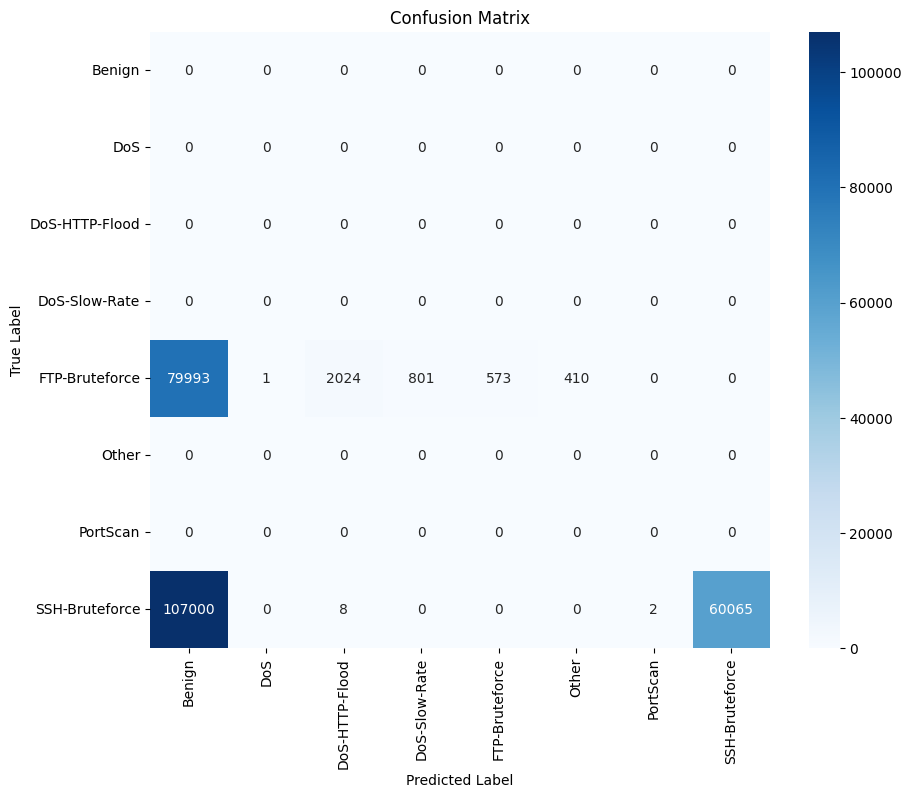

In [15]:
# prompt: do confusion matrix of the from sklearn.metrics import classification_report
# all_true_labels = []
# all_predicted_labels = []
# for attack in attacks:
#     pcap_files = os.listdir(f'/content/{attack}')
#     for pcap_file in pcap_files:
#         file_name = pcap_file.split('.')[0]
#         prediction_file_name = f'{file_name}_prediction.csv'
#         prediction_file_dir = f'/content/{attack}_prediction/'
#         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
#         try:
#             df_prediction = pd.read_csv(prediction_csv_path)
#             # The true label for all packets in this file is the 'attack' name
#             if attack != 'DoS-SlowRate':
#                 true_label = attack
#             else:
#                 true_label = 'DoS-Slow-Rate'
#             # Collect the predicted label for each packet from 'Chosen_Label'
#             predicted_labels = df_prediction['Chosen_Label'].tolist()
#             # Extend our master lists
#             all_true_labels.extend([true_label] * len(predicted_labels))
#             all_predicted_labels.extend(predicted_labels)
#         except FileNotFoundError:
#             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
#         except Exception as e:
#             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # Now, print the classification report using the collected true and predicted labels
# if all_true_labels and all_predicted_labels:
#     print("\n--- Classification Report ---")
#     # Ensure both lists are of the same length
#     if len(all_true_labels) == len(all_predicted_labels):
#         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
#     else:
#         print("Error: Mismatch in the number of true labels and predicted labels.")
# else:
#     print("\nNo data collected to generate a classification report.") too

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
# Ensure the unique labels are consistent across true and predicted lists
unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

if all_true_labels and all_predicted_labels and len(all_true_labels) == len(all_predicted_labels):
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    print("\n--- Confusion Matrix ---")
    print(cm)

    # Optional: Visualize the confusion matrix using seaborn and matplotlib
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nCannot generate Confusion Matrix: Mismatch in the number of true labels and predicted labels or no data collected.")



--- Confusion Matrix for bruteforce_ftp.pcap ---
[[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [47967     1   968   312   163   328]
 [    0     0     0     0     0     0]]


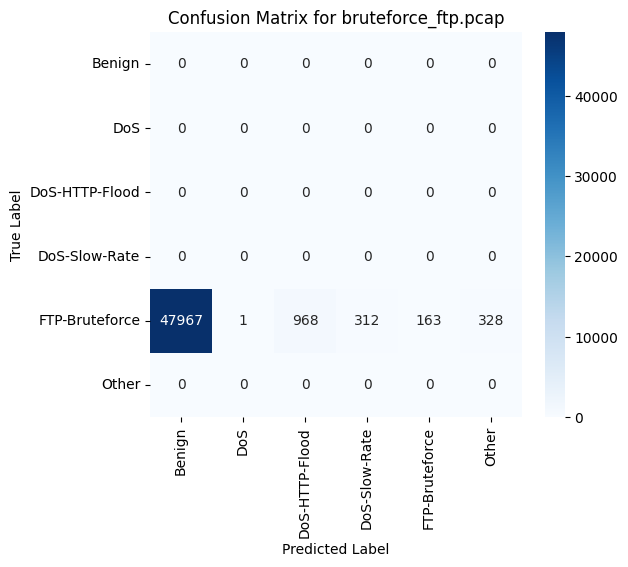


--- Confusion Matrix for ftpbrute-kali.pcap ---
[[    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [12973   484   202   162    17]
 [    0     0     0     0     0]]


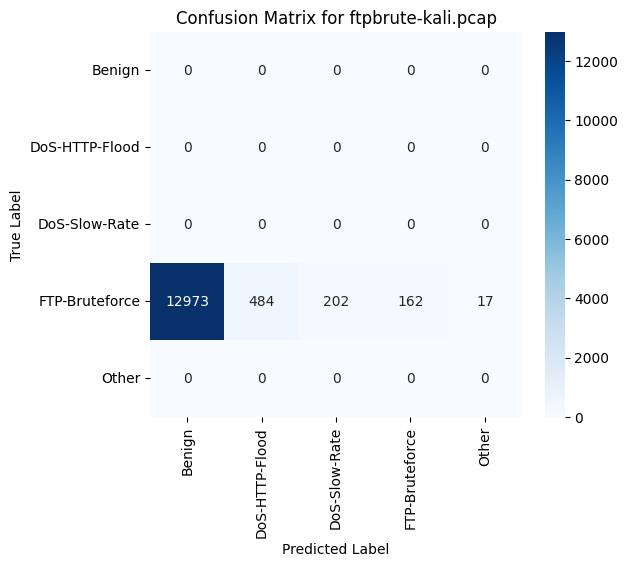


--- Confusion Matrix for ftpbrute-ubuntu.pcap ---
[[    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [19053   572   287   248    65]
 [    0     0     0     0     0]]


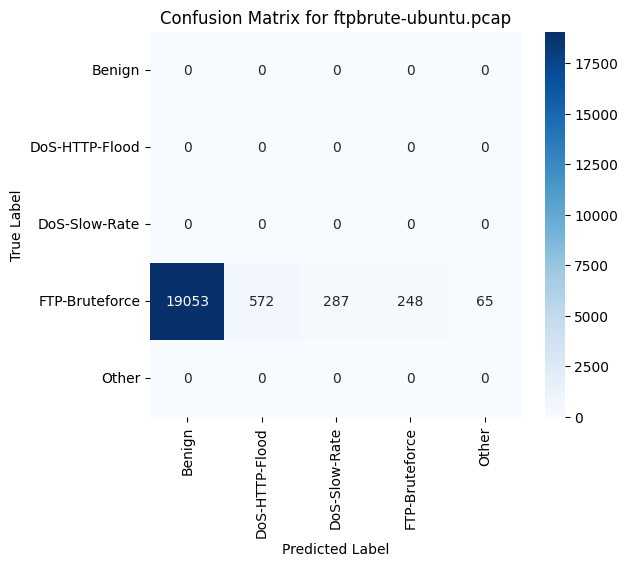


--- Confusion Matrix for sshbrute-ubuntu.pcap ---
[[    0     0     0]
 [    0     0     0]
 [20737     2  7197]]


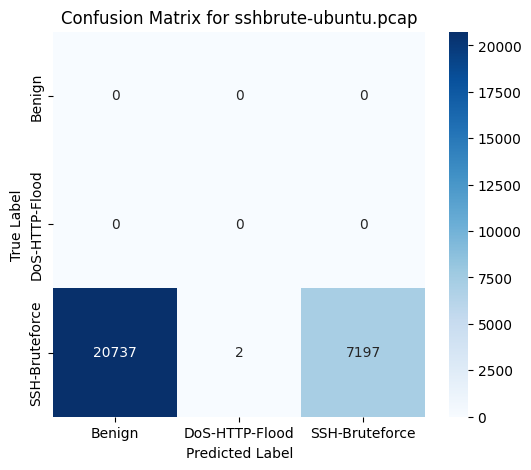


--- Confusion Matrix for sshbrute-kali.pcap ---
[[    0     0     0]
 [    0     0     0]
 [20100     3  6848]]


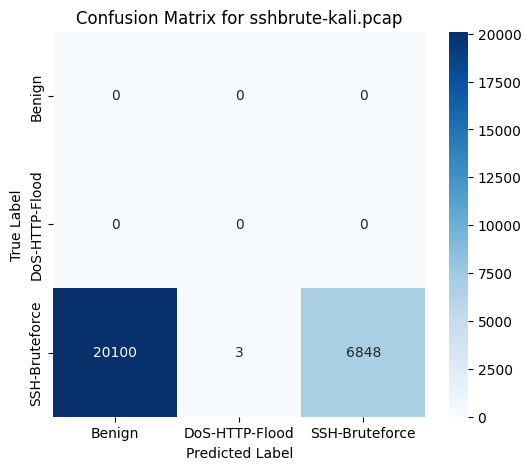


--- Confusion Matrix for bruteforce_ssh.pcap ---
[[    0     0     0     0]
 [    0     0     0     0]
 [    0     0     0     0]
 [66163     3     2 46020]]


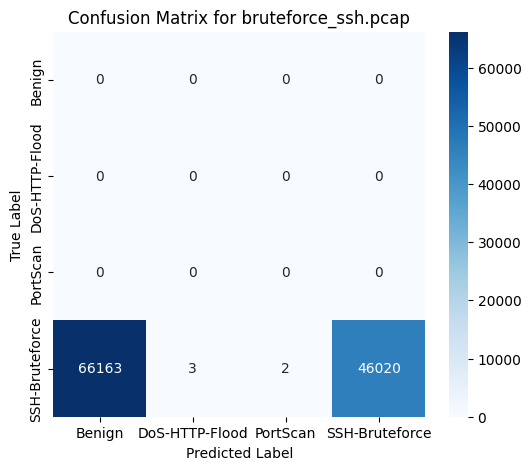

In [16]:

# prompt: print confsion matrix of each pcap file instead possible?
# # prompt: do confusion matrix of the from sklearn.metrics import classification_report
# # all_true_labels = []
# # all_predicted_labels = []
# # for attack in attacks:
# #     pcap_files = os.listdir(f'/content/{attack}')
# #     for pcap_file in pcap_files:
# #         file_name = pcap_file.split('.')[0]
# #         prediction_file_name = f'{file_name}_prediction.csv'
# #         prediction_file_dir = f'/content/{attack}_prediction/'
# #         prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'
# #         try:
# #             df_prediction = pd.read_csv(prediction_csv_path)
# #             # The true label for all packets in this file is the 'attack' name
# #             if attack != 'DoS-SlowRate':
# #                 true_label = attack
# #             else:
# #                 true_label = 'DoS-Slow-Rate'
# #             # Collect the predicted label for each packet from 'Chosen_Label'
# #             predicted_labels = df_prediction['Chosen_Label'].tolist()
# #             # Extend our master lists
# #             all_true_labels.extend([true_label] * len(predicted_labels))
# #             all_predicted_labels.extend(predicted_labels)
# #         except FileNotFoundError:
# #             print(f"Prediction file not found for {pcap_file}: {prediction_csv_path}")
# #         except Exception as e:
# #             print(f"Error processing prediction file {prediction_csv_path}: {e}")
# # # Now, print the classification report using the collected true and predicted labels
# # if all_true_labels and all_predicted_labels:
# #     print("\n--- Classification Report ---")
# #     # Ensure both lists are of the same length
# #     if len(all_true_labels) == len(all_predicted_labels):
# #         print(classification_report(all_true_labels, all_predicted_labels, zero_division=0))
# #     else:
# #         print("Error: Mismatch in the number of true labels and predicted labels.")
# # else:
# #     print("\nNo data collected to generate a classification report.")

# Print confusion matrix for each pcap file
for attack in attacks:
    pcap_files = os.listdir(f'/content/{attack}')
    for pcap_file in pcap_files:
        file_name = pcap_file.split('.')[0]
        prediction_file_name = f'{file_name}_prediction.csv'
        prediction_file_dir = f'/content/{attack}_prediction/'
        prediction_csv_path = f'{prediction_file_dir}/{prediction_file_name}'

        try:
            df_prediction = pd.read_csv(prediction_csv_path)

            # Determine the true label for this file
            if attack != 'DoS-SlowRate':
                true_label = attack
            else:
                true_label = 'DoS-Slow-Rate'

            # Extract true and predicted labels for this specific file
            true_labels_file = [true_label] * len(df_prediction)
            predicted_labels_file = df_prediction['Result'].tolist()

            print(f"\n--- Confusion Matrix for {pcap_file} ---")

            if true_labels_file and predicted_labels_file and len(true_labels_file) == len(predicted_labels_file):
                # Get all unique labels present in both true and predicted lists for this file
                unique_labels_file = sorted(list(set(true_labels_file + predicted_labels_file)))

                # Generate confusion matrix for this file
                cm_file = confusion_matrix(true_labels_file, predicted_labels_file, labels=unique_labels_file)
                print(cm_file)

                # Optional: Visualize the confusion matrix for this file
                plt.figure(figsize=(6, 5))
                sns.heatmap(cm_file, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels_file, yticklabels=unique_labels_file)
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title(f'Confusion Matrix for {pcap_file}')
                plt.show()
            else:
                print(f"No valid data to generate confusion matrix for {pcap_file}.")

        except FileNotFoundError:
            print(f"\nPrediction file not found for {pcap_file}: {prediction_csv_path}")
        except Exception as e:
            print(f"\nError processing prediction file {prediction_csv_path}: {e}")




In [17]:
# prompt: print every result as dataframe display

from IPython.display import display

for attack in attacks:
    result_csv_path = f'/content/Result/{attack}_result.csv'
    if os.path.exists(result_csv_path):
        df_result = pd.read_csv(result_csv_path)
        print(f"\n--- Results for {attack} ---")
        print(df_result)
    else:
        print(f"\nNo result file found for {attack}.")
    print("-" * 40)


--- Results for FTP-Bruteforce ---
                         FileName          Result          Attack
0   bruteforce_ftp_prediction.csv  DoS-HTTP-Flood  FTP-Bruteforce
1  ftpbrute-ubuntu_prediction.csv  DoS-HTTP-Flood  FTP-Bruteforce
2    ftpbrute-kali_prediction.csv  DoS-HTTP-Flood  FTP-Bruteforce
----------------------------------------

--- Results for SSH-Bruteforce ---
                         FileName          Result          Attack
0  sshbrute-ubuntu_prediction.csv  SSH-Bruteforce  SSH-Bruteforce
1    sshbrute-kali_prediction.csv  SSH-Bruteforce  SSH-Bruteforce
2   bruteforce_ssh_prediction.csv  SSH-Bruteforce  SSH-Bruteforce
----------------------------------------


# Prediction setup (speed run)

In [ ]:
!pip install scapy

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scapy.all import PcapReader, IP, TCP
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()

# Load tokenizer and model once (replace model path with your model)
tokenizer = AutoTokenizer.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
model = AutoModelForSequenceClassification.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload").to(device)
model.eval()

classes = [
    'Analysis', 'Backdoor', 'Bot', 'DDoS', 'DoS', 'DoS GoldenEye', 'DoS Hulk',
    'DoS SlowHTTPTest', 'DoS Slowloris', 'Exploits', 'FTP Patator', 'Fuzzers',
    'Generic', 'Heartbleed', 'Infiltration', 'Normal', 'Port Scan',
    'Reconnaissance', 'SSH Patator', 'Shellcode', 'Web Attack - Brute Force',
    'Web Attack - SQL Injection', 'Web Attack - XSS', 'Worms'
]

packets_brief = {}

def processing_packet_conversion(packet):
    # your existing function, unchanged
    packet_2 = packet
    protocol_counts = {}
    protocols = []

    while packet_2:
        layer = packet_2[0]
        protocol_counts[layer.name] = protocol_counts.get(layer.name, 0) + 1
        protocols.append(layer.name)

        if not layer.payload:
            break
        packet_2 = layer.payload

    src_ip = packet[IP].src
    dst_ip = packet[IP].dst
    src_port = packet.sport
    dst_port = packet.dport
    ip_length = len(packet[IP])
    ip_ttl = packet[IP].ttl
    ip_tos = packet[IP].tos
    tcp_data_offset = packet[TCP].dataofs
    tcp_flags = packet[TCP].flags

    payload_bytes = bytes(packet.payload)
    payload_length = len(payload_bytes)
    payload_decimal = ' '.join(str(byte) for byte in payload_bytes)

    final_data = (
        "0 0 195 -1 "
        f"{src_port} {dst_port} {ip_length} {payload_length} "
        f"{ip_ttl} {ip_tos} {tcp_data_offset} {int(tcp_flags)} -1 {payload_decimal}"
    )
    return final_data

def batch_predict_pcap(file_path, batch_size=32, filter_bytes=None):
    global model # Declare model as global

    # Read and prepare inputs
    texts = []
    packets_nbr = 0

    with PcapReader(file_path) as pcap:
        for pkt in pcap:
            if IP in pkt and TCP in pkt:
                payload_bytes = bytes(pkt.payload)
                if filter_bytes is None or filter_bytes in payload_bytes:
                    text = processing_packet_conversion(pkt)
                    if text:
                        texts.append(text[:1024])  # truncate to 1024 chars
                        packets_nbr += 1

    print(f"Collected {packets_nbr} TCP/IPv4 packets matching filter")

    # Batched tokenization and DataLoader
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    model.eval()
    if use_fp16:
        # Convert model to half precision, but leave input_ids as is
        model = model.half()

    all_preds = []

    for batch in loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Only convert attention_mask to half precision if using fp16
        if use_fp16:
             attention_mask = attention_mask.half()


        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().tolist()

            # Collect predicted classes and count non-normal
            for pred in preds:
                pred_class = classes[pred]
                if pred_class != "Normal":
                    packets_brief[pred_class] = packets_brief.get(pred_class, 0) + 1

            all_preds.extend(preds)

    # Print summary
    for attack, count in packets_brief.items():
        print(f"{attack}: {count}")

    # Plot results
    if packets_brief:
        keys = list(packets_brief.keys())
        vals = list(packets_brief.values())
        plt.bar(keys, vals)
        plt.xlabel('Attacks')
        plt.ylabel('Count')
        plt.title('Detected possible attacks')
        plt.show()
    else:
        print("No attacks detected.")

Collected 19730 TCP/IPv4 packets matching filter
FTP Patator: 266
Heartbleed: 15
Fuzzers: 126
Generic: 3
DoS GoldenEye: 960
Exploits: 142
DoS SlowHTTPTest: 4
DoS: 4


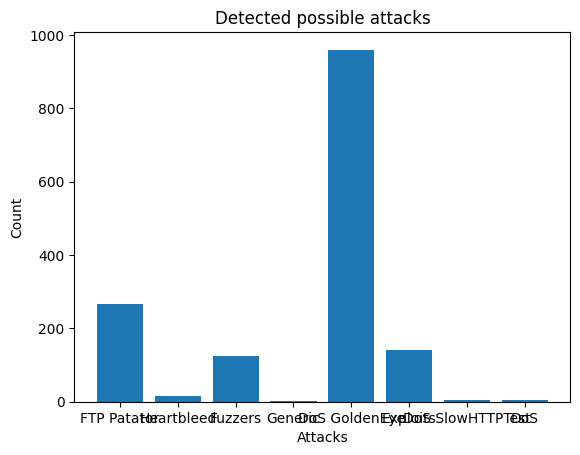

In [ ]:
# Example usage
batch_predict_pcap("/content/ftp-crack.pcap", filter_bytes=b"")

# Archive Prediction setup

In [23]:
!pip install scapy

In [24]:
# ======================
# Imports
# ======================
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scapy.all import rdpcap, Raw
import pandas as pd
import os

# ======================
# Device + FP16 Setup
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()
print(f"Using device: {device} {'(fp16)' if use_fp16 else '(fp32)'}")

# ======================
# Load Model + Tokenizer
# ======================
tokenizer = AutoTokenizer.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
model = AutoModelForSequenceClassification.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
if use_fp16:
    model = model.half()
model = model.to(device)
model.eval()

Using device: cuda (fp16)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [25]:
# ======================
# Attack Class List
# ======================
classes = [
    'Analysis', 'Backdoor', 'Bot', 'DDoS', 'DoS', 'DoS GoldenEye', 'DoS Hulk',
    'DoS SlowHTTPTest', 'DoS Slowloris', 'Exploits', 'FTP Patator', 'Fuzzers',
    'Generic', 'Heartbleed', 'Infiltration', 'Normal', 'Port Scan',
    'Reconnaissance', 'SSH Patator', 'Shellcode', 'Web Attack - Brute Force',
    'Web Attack - SQL Injection', 'Web Attack - XSS', 'Worms'
]

# ======================
# Class Mapping
# ======================
classes_mapping = {
    'Analysis': 'Other', 'Backdoor': 'Other', 'Bot': 'Other', 'DDoS': 'Other',
    'DoS': 'DoS', 'DoS GoldenEye': 'DoS-HTTP-Flood', 'DoS Hulk': 'DoS-HTTP-Flood',
    'DoS SlowHTTPTest': 'DoS-Slow-Rate', 'DoS Slowloris': 'DoS-Slow-Rate',
    'Exploits': 'Other', 'FTP Patator': 'FTP-Bruteforce', 'Fuzzers': 'Other',
    'Generic': 'Other', 'Heartbleed': 'Other', 'Infiltration': 'Other',
    'Normal': 'Benign', 'Port Scan': 'PortScan', 'Reconnaissance': 'Other',
    'SSH Patator': 'SSH-Bruteforce', 'Shellcode': 'Other',
    'Web Attack - Brute Force': 'Other', 'Web Attack - SQL Injection': 'Other',
    'Web Attack - XSS': 'Other', 'Worms': 'Other',
}

# ======================
# Convert Packet to Text
# ======================
def packet_to_text(pkt):
    summary = pkt.summary()
    payload = pkt[Raw].load.hex() if Raw in pkt else ""
    return summary + " " + payload

# ======================
# Predict From PCAP
# ======================
def predict_pcap(filepath):
    packets = rdpcap(filepath)
    texts = [packet_to_text(pkt) for pkt in packets]

    predictions = []
    batch_size = 16  # T4-safe

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        if use_fp16:
            inputs = {k: v.half() if v.dtype == torch.float else v for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)

    df = pd.DataFrame({
        'Packet_Indices': list(range(len(predictions))),
        'Predicted_Attack': [classes[p] for p in predictions]
    })

    df['Result'] = df['Predicted_Attack'].map(classes_mapping)

    return df


In [26]:
# ======================
# Process All PCAPs in Folder
# ======================

for attack in attacks:
    print(f"Processing folder: {attack}")
    folder_path = f'/content/{attack}/'
    output_folder = f'/content/{attack}_prediction'
    os.makedirs(output_folder, exist_ok=True)

    files = [f for f in os.listdir(folder_path) if f.endswith('.pcap')]

    for file in files:
        print(f"  Processing: {file}")
        file_path = os.path.join(folder_path, file)
        result_df = predict_pcap(file_path)

        output_file = file.replace('.pcap', '_prediction.csv')
        result_df.to_csv(os.path.join(output_folder, output_file), index=False)
        print(f"    Saved to {output_file}")

Processing folder: FTP-Bruteforce
  Processing: bruteforce_ftp.pcap
    Saved to bruteforce_ftp_prediction.csv
  Processing: ftpbrute-kali.pcap
    Saved to ftpbrute-kali_prediction.csv
  Processing: ftpbrute-ubuntu.pcap
    Saved to ftpbrute-ubuntu_prediction.csv
Processing folder: SSH-Bruteforce
  Processing: sshbrute-ubuntu.pcap
    Saved to sshbrute-ubuntu_prediction.csv
  Processing: sshbrute-kali.pcap
    Saved to sshbrute-kali_prediction.csv
  Processing: bruteforce_ssh.pcap
    Saved to bruteforce_ssh_prediction.csv


In [34]:
import pandas as pd

test = pd.read_csv('/content/FTP-Bruteforce_prediction/ftpbrute-ubuntu_prediction.csv')

In [35]:
test['Result'].value_counts()

,count
Result,
Benign,19199
Other,1085
DoS,52
DoS-Slow-Rate,4


In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scapy.all import rdpcap, Raw
import pandas as pd

# --- Configs and setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()  # Use mixed precision only if CUDA available

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
model = AutoModelForSequenceClassification.from_pretrained("rdpahalavan/bert-network-packet-flow-header-payload")
model = model.to(device)
model.eval()

# Classes & mapping (same as yours)
classes = [
    'Analysis', 'Backdoor', 'Bot', 'DDoS', 'DoS', 'DoS GoldenEye', 'DoS Hulk',
    'DoS SlowHTTPTest', 'DoS Slowloris', 'Exploits', 'FTP Patator', 'Fuzzers',
    'Generic', 'Heartbleed', 'Infiltration', 'Normal', 'Port Scan',
    'Reconnaissance', 'SSH Patator', 'Shellcode', 'Web Attack - Brute Force',
    'Web Attack - SQL Injection', 'Web Attack - XSS', 'Worms'
]

classes_mapping = {
    'Analysis': 'Other', 'Backdoor': 'Other', 'Bot': 'Other', 'DDoS': 'Other',
    'DoS': 'DoS', 'DoS GoldenEye': 'DoS-HTTP-Flood', 'DoS Hulk': 'DoS-HTTP-Flood',
    'DoS SlowHTTPTest': 'DoS-Slow-Rate', 'DoS Slowloris': 'DoS-Slow-Rate',
    'Exploits': 'Other', 'FTP Patator': 'FTP-Bruteforce', 'Fuzzers': 'Other',
    'Generic': 'Other', 'Heartbleed': 'Other', 'Infiltration': 'Other',
    'Normal': 'Benign', 'Port Scan': 'PortScan', 'Reconnaissance': 'Other',
    'SSH Patator': 'SSH-Bruteforce', 'Shellcode': 'Other',
    'Web Attack - Brute Force': 'Other', 'Web Attack - SQL Injection': 'Other',
    'Web Attack - XSS': 'Other', 'Worms': 'Other',
}

# --- Packet to text ---
def packet_to_text(pkt):
    summary = pkt.summary()
    payload = pkt[Raw].load.hex() if Raw in pkt else ""
    return summary + " " + payload

# --- Prediction - Original style (single sample, fp32) ---
def predict_single(packets):
    preds = []
    for pkt in packets:
        text = packet_to_text(pkt)
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            preds.append(pred)
    return preds

# --- Prediction - Batched, optional fp16 ---
def predict_batch(packets, batch_size=16):
    texts = [packet_to_text(pkt) for pkt in packets]
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        if use_fp16:
            inputs = {k: v.half() if v.dtype == torch.float else v for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().tolist()
            preds.extend(batch_preds)
    return preds

# --- Main test function ---
def test_pcap(filepath):
    packets = rdpcap(filepath)
    print(f"Loaded {len(packets)} packets from {filepath}")

    preds_single = predict_single(packets)
    preds_batch = predict_batch(packets)

    # Compare first 20 predictions side-by-side
    print(f"{'Index':>5} | {'Single':>15} | {'Batch':>15} | {'Match':>5}")
    print("-" * 50)
    for i in range(min(20, len(packets))):
        single_label = classes[preds_single[i]]
        batch_label = classes[preds_batch[i]]
        match = "Yes" if single_label == batch_label else "No"
        print(f"{i:5} | {single_label:15} | {batch_label:15} | {match:5}")

    # Return detailed DataFrame if needed
    df = pd.DataFrame({
        "Packet_Index": list(range(len(packets))),
        "Predicted_Single": [classes[p] for p in preds_single],
        "Predicted_Batch": [classes[p] for p in preds_batch],
    })
    return df

# --- Run the test ---
if __name__ == "__main__":
    test_filepath = "bruteforce.pcap"  # <-- change this to your PCAP path
    df_results = test_pcap(test_filepath)


Loaded 606 packets from bruteforce.pcap
Index |          Single |           Batch | Match
--------------------------------------------------
    0 | Normal          | Normal          | Yes  
    1 | Normal          | Normal          | Yes  
    2 | Normal          | Normal          | Yes  
    3 | Normal          | Normal          | Yes  
    4 | Normal          | Normal          | Yes  
    5 | Normal          | Normal          | Yes  
    6 | Normal          | Normal          | Yes  
    7 | Normal          | Normal          | Yes  
    8 | Normal          | Normal          | Yes  
    9 | Normal          | Normal          | Yes  
   10 | Normal          | Normal          | Yes  
   11 | Normal          | Normal          | Yes  
   12 | Normal          | Normal          | Yes  
   13 | Normal          | Normal          | Yes  
   14 | Normal          | Normal          | Yes  
   15 | Normal          | Normal          | Yes  
   16 | Normal          | Normal          | Yes  
   17 | N

# Archive

In [10]:
result, total_packet = predictingRowsCategory("/content/dosattack.pcap", b"")

Loading pcap file...
Pcap file loaded.
Couting packets file...
total_packet (counted):  100
Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,

In [12]:
result

,PredictedAttack
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
95,Normal
96,Normal
97,Normal
98,Normal


In [14]:
classes_mapping = {
 'Analysis': 'Other',
 'Backdoor': 'Other',
 'Bot': 'Other',
 'DDoS': 'Other',
 'DoS': 'DoS',
 'DoS GoldenEye' : 'DoS-HTTP-Flood',
 'DoS Hulk': 'DoS-HTTP-Flood',
 'DoS SlowHTTPTest' : 'DoS-Slow-Rate',
 'DoS Slowloris': 'DoS-Slow-Rate',
 'Exploits': 'Other',
 'FTP Patator' : 'FTP-Bruteforce',
 'Fuzzers': 'Other',
 'Generic': 'Other',
 'Heartbleed': 'Other',
 'Infiltration': 'Other',
 'Normal' : 'Benign',
 'Port Scan' : 'PortScan',
 'Reconnaissance': 'Other',
 'SSH Patator' : 'SSH-Bruteforce',
 'Shellcode': 'Other',
 'Web Attack - Brute Force': 'Other',
 'Web Attack - SQL Injection': 'Other',
 'Web Attack - XSS': 'Other',
 'Worms': 'Other',
}
result['Result'] = result['PredictedAttack'].map(classes_mapping)
result

,PredictedAttack,MappedAttack,Result
0,Normal,Benign,Benign
1,Normal,Benign,Benign
2,Normal,Benign,Benign
3,Normal,Benign,Benign
4,Normal,Benign,Benign
...,...,...,...
95,Normal,Benign,Benign
96,Normal,Benign,Benign
97,Normal,Benign,Benign
98,Normal,Benign,Benign


In [15]:
result['Result'].value_counts()

,count
Result,
Benign,100
